In [8]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt



In [4]:
spark = SparkSession.builder \
    .appName("DataCleaningWithHive") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()


In [ ]:

# Utiliser zipWithIndex pour ajouter un index à chaque ligne, puis filtrer la première ligne
df_client = df_client.rdd.zipWithIndex().filter(lambda row_index: row_index[1] > 0).map(lambda row_index: row_index[0]).toDF(df_client.schema)


In [7]:
spark.sql("USE concessionnaire")
df_client = spark.sql("SELECT * FROM client_data")  
df_client

DataFrame[age: string, sexe: string, taux: string, situationfamilliale: string, nbenfantacharge: string, deuxiemevoiture: string, immatriculation: string]

+--------+-----+
|    sexe|count|
+--------+-----+
|       F|29185|
|Masculin|  702|
| F�minin|  258|
|       M|68573|
|    sexe|    1|
|     N/D|   83|
|   Femme|  306|
|        |  118|
|   Homme|  667|
|       ?|  108|
+--------+-----+



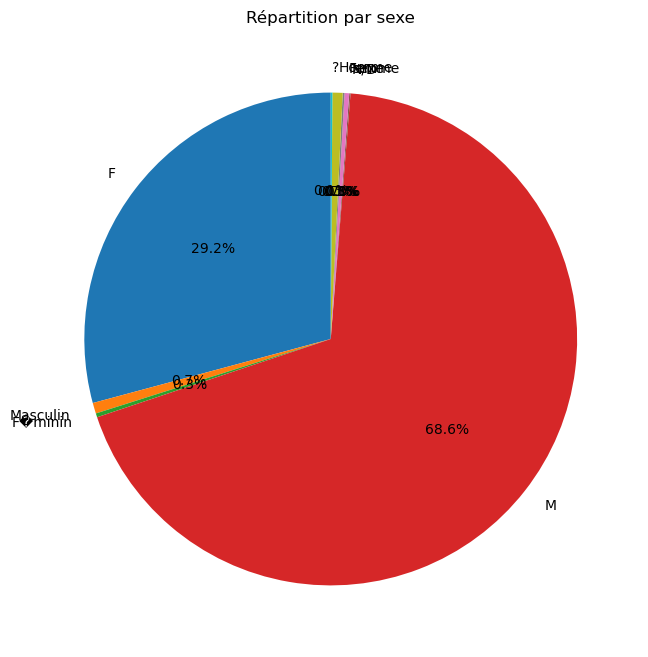

In [9]:

# Compter les occurrences des valeurs dans la colonne sexe
sexe_distribution = df_client.groupBy("sexe").count()
sexe_distribution.show()

# Conversion en Pandas DataFrame
sexe_distribution_pd = sexe_distribution.toPandas()

# Préparer les données
labels = sexe_distribution_pd['sexe']
sizes = sexe_distribution_pd['count']

# Créer le graphique
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Répartition par sexe')
plt.show()
